In [1]:
import pandas as pd

import json
from pprint import pprint

#Use gensim, which remove stop words, short words(<3 letters), puncts and do stemming
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string


from collections import Counter
import numpy as np


from gensim.models import AuthorTopicModel
from gensim.corpora import mmcorpus
from gensim.test.utils import common_dictionary, datapath, temporary_file

from gensim import corpora

import pickle
import logging

import numpy as np
import matplotlib


from matplotlib import pyplot as plt
%matplotlib inline

In [160]:
from lib.ATM import ATM,get_top_words
from sklearn.linear_model import LogisticRegression


In [3]:
import pickle as pkl
with open('states.pkl','rb') as file:
    states=pkl.load(file)

import json 
with open('propseconddebate.json','r') as json_file:
    text=json.load(json_file)

t_ids=list(text['full_text'].keys())

In [116]:
# with open('filterDEM.json','r') as json_file:
#     DEM=json.load(json_file)

In [67]:
# locs=[]
# for ID in t_ids:
#     if text['user'][ID][19]!='':
#         locs.append(text['user'][ID][19])

In [68]:
# locs

In [69]:
# with open('firstdebat_cleaned.json','r') as json_file:
#     text=json.load(json_file)

In [4]:
#Reorganize json file into a pd dataframe odf

ID2UID={}

for ID in t_ids:
    UID=text['user'][ID][13]
    ID2UID[ID]=UID


states_full=set(list(states.values()))

states_abb=set(list(states.keys()))

ID2loc={}

#get place from place attribute
# for ID in t_ids:
#     loc=text['place'][ID][4].split()
#     if len(loc)>1:
#         if loc[0] in states_full:
#             ID2loc[ID]=loc[0]
#         elif loc[1] in states_abb:
#             ID2loc[ID]=states[loc[1]]
            
#get place from user attribute
for ID in t_ids:
    loc= text['user'][ID][19].split()
    if len(loc)>1:
        if loc[0] in states_full:
            ID2loc[ID]=loc[0]
        if loc[1] in states_full:
            ID2loc[ID]=loc[1]
        elif loc[0].upper() in states_abb:
                ID2loc[ID]=states[loc[0].upper()]
        elif loc[1].upper() in states_abb:
            ID2loc[ID]=states[loc[1].upper()]
        
#     print(text['place'][ID][4])

valid_ids=set(ID2loc.keys())

ID2text={}
for ID in t_ids:
    sent=text['full_text'][ID]
    if ID in valid_ids:
        ID2text[ID]=sent

IDs=[]
sents=[]
locs=[]
UIDs=[]
for ID in valid_ids:
    IDs.append(ID)
    sents.append(ID2text[ID])
    locs.append(ID2loc[ID])
    UIDs.append(ID2UID[ID])
df={'ID':IDs,'text':sents,'state':locs,'uid':UIDs}

odf=pd.DataFrame.from_dict(df)

In [5]:
odf.head()

,ID,text,state,uid
0,66360,@realDonaldTrump probably thinks the West Memp...,Pennsylvania,2516977465
1,45391,RT @elizarledge: When their home is at stake i...,Mississippi,2869699381
2,12823,RT @fightfor15: #FightFor15 workers will be at...,Texas,55009781
3,26265,"RT @HillaryClinton: ""Latinas still make 55 cen...",Florida,3391230298
4,179284,@realDonaldTrump is a coward. No press confere...,Texas,107589468


In [6]:
len(odf)

42042

In [7]:
number_uid=(odf.groupby('uid').count()['ID'])
good_uid=set(number_uid[number_uid<5].index.values)
odf=odf[odf.uid.isin(good_uid)]

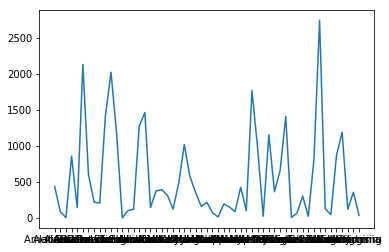

In [8]:
plt.plot(odf.groupby('state').count()['ID'])

In [9]:
#drop states with less than 300 tweets
number_tweets=odf.groupby('state').count()['ID']
good_states=set(number_tweets[number_tweets>300].index.values)

odf=odf[odf.state.isin(good_states)]

In [10]:
# Tokenize tweets

documents=odf['text'].values

from gensim.parsing.preprocessing import *
CUSTOM_FILTERS = [lambda x: x.lower(),strip_multiple_whitespaces,remove_stopwords, strip_non_alphanum,strip_numeric,lambda x: strip_short(x,minsize=3)]

filtered_docs=list(map(lambda t:preprocess_string(t, CUSTOM_FILTERS),documents))

texts=filtered_docs

from collections import defaultdict
frequency = Counter()

for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if (frequency[token] > 2) and (frequency[token]<200)] for text in texts]


In [11]:
#add filtered text to odf, but remove empty ones
odf['filtered']=texts
odf['filtered_len']=list(map(lambda x:len(x),texts))
odf_c=odf[odf['filtered_len']>0]
texts=odf_c['filtered'].values

In [12]:

n=0
author2doc={}
for author in states.values():
    author2doc[author]=[]

for author in odf_c['state'].values:
    author2doc[author].append(int(n))
    n+=1

author_name={}
author2id={}
nstates=np.unique(odf_c['state'].values)
for i in range(len(nstates)):
    author_name[i]=nstates[i]
    author2id[nstates[i]]=i

In [13]:
import os
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join('temp.dict'))
#indexize words and tweets
corpus = [dictionary.doc2bow(text) for text in texts]

#generate author2doc dic
n=0
author2doc={}
for author in states.values():
    author2doc[author]=[]

for author in odf_c['state'].values:
    author2doc[author].append(int(n))
    n+=1

In [14]:
#indexize states
author_name={}
author2id={}
nstates=np.unique(odf_c['state'].values)
for i in range(len(nstates)):
    author_name[i]=nstates[i]
    author2id[nstates[i]]=i

In [15]:
#input corpus for our ATM model
new_corpus=[]
for tweet in corpus:
    new_data=[]
    for pair in tweet:
        new_data+=[pair[0]]*pair[1]
    new_corpus.append(new_data)

In [16]:
# A new word dic for our model input
new_dic={}
for key in dictionary.keys():
    new_dic[key]=dictionary[key]

In [17]:
voca=[new_dic[i] for i in range(len(new_dic.keys()))]

In [18]:
len(voca)

4358

In [20]:
#generate docauthor list for our model input
doc_author=np.arange(len(new_corpus))

for pair in author2doc.items():
#     print(pair)
    for doc_id in pair[1]:
        doc_author[doc_id]=author2id[pair[0]]

doc_author=[[i] for i in doc_author]

In [21]:
#model hyperparameters
n_doc = len(corpus)
n_topic = 300
n_author = len(author_name)
n_voca = len(voca)
max_iter = 25

In [22]:
model = ATM(n_doc, n_voca, n_topic, n_author)
model.fit(new_corpus, doc_author, max_iter=max_iter)

 0 elapsed_time: 4.303560972213745 log_likelihood: -961925.6121729154
Perplexity 2542.636050178397
 1 elapsed_time: 4.342651128768921 log_likelihood: -907854.8372159792
Perplexity 2503.335242265519
 2 elapsed_time: 4.361605644226074 log_likelihood: -881874.0529397473
Perplexity 2460.6253326037213
 3 elapsed_time: 4.33298921585083 log_likelihood: -866098.5842621856
Perplexity 2435.026933305533
 4 elapsed_time: 4.350955009460449 log_likelihood: -854179.5978286116
Perplexity 2414.0192590652036
 5 elapsed_time: 4.3802876472473145 log_likelihood: -844057.660135508
Perplexity 2400.43361793533
 6 elapsed_time: 4.342634916305542 log_likelihood: -836687.9016003669
Perplexity 2386.9418073041165
 7 elapsed_time: 4.346031904220581 log_likelihood: -830694.6302732324
Perplexity 2380.5773926531797
 8 elapsed_time: 4.410059928894043 log_likelihood: -824238.0612193521
Perplexity 2362.8848139079146
 9 elapsed_time: 4.34222412109375 log_likelihood: -818377.1474162553
Perplexity 2359.7088791082365
 10 ela

In [23]:
model.perplexity(new_corpus, doc_author)

2345.331853558358

In [256]:
# for k in range(n_topic):
#     top_words = get_top_words(model.TW, voca, k, 10)
#     print('topic ', k , ','.join(top_words))

In [24]:
k=100
get_top_words(model.TW, voca, k, 30)

array(['more', 'grope', 'girl', 'citizens', 'theresamechele', 'loose',
       'positions', 'billybush', 'repeal', 'scotusatstake', 'nice',
       'losing', 'fox', 'dirt', 'reference', 'dumbass', 'alert', 'texas',
       'pages', 'kinds', 'amjoy', 'syrian', 'felonious', 'major',
       'resources', 'gore', 'pandering', 'odell', 'murders', 'frog'],
      dtype='<U21')

In [25]:
normalized_AT=[]
for author_id in range(len(author_name.values())):
    normalized_AT.append((model.AT[author_id,:]/np.sum(model.AT[author_id,:])))

normalized_AT=np.array(normalized_AT)

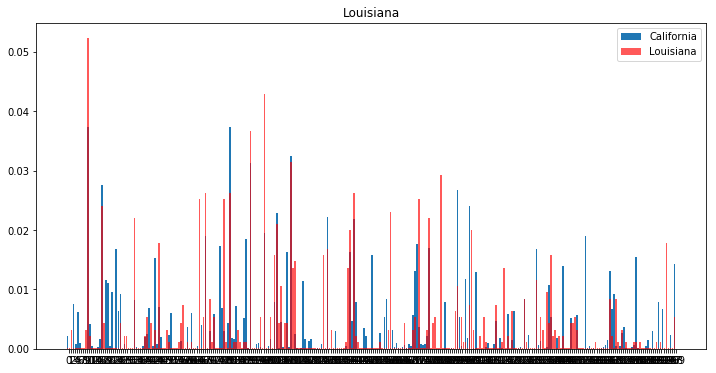

In [26]:
author_id = 2
fig = plt.figure(figsize=(12,6))
plt.bar(range(n_topic), normalized_AT[author_id,:],label=author_name[author_id])
author_id = 11
plt.bar(range(n_topic), normalized_AT[author_id,:],color='r',alpha=0.65,label=author_name[author_id])
plt.legend()
plt.title(author_name[author_id])
# plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(model.TW, voca, k, 10)) for k in range(n_topic)])
plt.xticks(np.arange(n_topic)+0.5, [k for k in range(n_topic)])
plt.show()

In [260]:
keyword='china'
for tweet in odf[odf.state=='Arizona'].text.values:
    if keyword in tweet:
        print(tweet)

@realDonaldTrump you're a bull in a china cabinet! Let her speak.


In [276]:
# odf[odf.state=='Arizona'].text.values

In [27]:
topic_stds=[]
for topic in range(n_topic):
    topic_stds.append(np.std(normalized_AT[:,topic]))

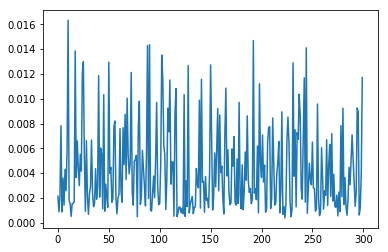

In [28]:
plt.plot(topic_stds)

In [29]:
sorted([(i,topic_stds[i]) for i in range(len(topic_stds))],key=lambda pair:pair[1],reverse=True)

[(10, 0.01633111796360954),
 (192, 0.014693266109412895),
 (90, 0.014358240798792866),
 (88, 0.014287091578241397),
 (244, 0.014108317178531072),
 (17, 0.013855750785049479),
 (102, 0.01352881621049556),
 (25, 0.01298749086659188),
 (50, 0.01295442855446219),
 (231, 0.012900776117503385),
 (150, 0.012730362827725314),
 (128, 0.012669014549728725),
 (72, 0.01211715798074454),
 (24, 0.012058528679973222),
 (40, 0.011866714396698778),
 (299, 0.011703738305682828),
 (242, 0.011691316366875445),
 (103, 0.011654871222156875),
 (141, 0.011561526616270988),
 (110, 0.011508750121144436),
 (198, 0.0112070878431928),
 (165, 0.010856709835259371),
 (116, 0.010817737708790305),
 (237, 0.010367911544087543),
 (124, 0.010324068598899819),
 (45, 0.01032158260573099),
 (68, 0.010047606862175455),
 (139, 0.009879113825109944),
 (80, 0.009805193351690902),
 (97, 0.009706849850002823),
 (178, 0.009705510330644294),
 (255, 0.009576034371518969),
 (294, 0.009251389712637273),
 (108, 0.009243710741751199),
 

In [30]:
(topic_stds[106])

0.0010649104582437143

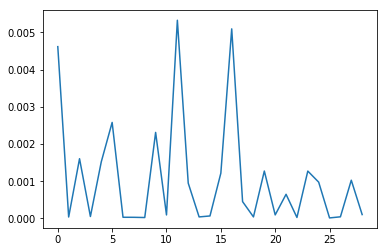

In [31]:
plt.plot(normalized_AT[:,100])

In [33]:
# comp=np.zeros((50,50))
# for i in range(50):
#     for j in range(50):
#         comp[i,j]=np.sum(np.abs((model.AT[i]/np.sum(model.AT[i]))-(model.AT[j]/np.sum(model.AT[j]))))

# Bootstrap

In [214]:
# red_states=['Wyoming', 'Idaho', 'Oklahoma', 'West Virginia', 'Kentucky','North Dakota', 'South Dakota', 'Nebraska', 'Alabama', 'Utah']
# blue_states=['Massachusetts', 'Maryland', 'Vermont','Hawaii', 'District of Columbia']

In [208]:
with open('three_parts.pkl','rb') as file:
    three_parts=pkl.load(file)

In [210]:
red_states,swing_states,blue_states=three_parts

In [213]:
# swing_states

In [231]:
author2id_lower={}
for pair in author2id.items():
    author2id_lower[pair[0].lower()]=pair[1]

In [232]:
red_states_ids=[]
for i in red_states:
    if i in author2id_lower:
        red_states_ids.append(author2id_lower[i])

In [233]:
blue_states_ids=[]
for i in blue_states:
    if i in author2id_lower:
        blue_states_ids.append(author2id_lower[i])

In [234]:
red_states_ids

[20, 10, 0, 24, 11, 9, 8, 25, 23, 6, 1]

In [235]:
blue_states_ids

[15, 21, 27, 16, 7, 2, 17, 13, 12, 4]

In [236]:
topic_means=[]
for topic in range(n_topic):
    topic_means.append(np.mean(normalized_AT[:,topic]))

In [237]:
red_means=[]
for t in range(n_topic):
    red_means.append(np.std(normalized_AT[red_states_ids,t]))

interest_red=[]
for n in np.arange(len(red_means)):
    if (red_means[n]>0.001) and (red_means[n]>topic_means[n]):
        interest_red.append(n)

In [238]:
blue_means=[]
for t in range(n_topic):
    blue_means.append(np.std(normalized_AT[blue_states_ids,t]))

interest_blue=[]
for n in np.arange(len(blue_means)):
    if (blue_means[n]>0.001) and (blue_means[n]>topic_means[n]):
        interest_blue.append(n)

In [239]:
std_cut=0.15
interest_cross_blue=[]
for n in np.arange(len(blue_means)):
    if (blue_means[n]>0.001) and (blue_means[n]>topic_means[n]+std_cut*topic_stds[n]) and (red_means[n]>0.001) and (red_means[n]<topic_means[n]-std_cut*topic_stds[n]):
        interest_cross_blue.append(n)

In [81]:
len(interest_cross_blue)

10

In [82]:
interest_cross_red=[]
for n in np.arange(len(red_means)):
    if (blue_means[n]>0.001) and (blue_means[n]<topic_means[n]-std_cut*topic_stds[n]) and (red_means[n]>0.001) and (red_means[n]>topic_means[n]+std_cut*topic_stds[n]):
        interest_cross_red.append(n)

In [83]:
len(interest_cross_red)

13

In [164]:
# red_stds=[]
# for t in range(n_topic):
#     red_stds.append(np.std(normalized_AT[red_states_ids,t]))

In [212]:
# interest_red=[]

# for n in np.arange(len(red_stds)):
#     if (red_stds[n]>0.001) and (red_stds[n]<topic_stds[n]*0.3):
#         interest_red.append(n)

In [217]:
# blue_stds=[]
# for t in range(n_topic):
#     blue_stds.append(np.std(normalized_AT[blue_states_ids,t]))
    
# interest_blue=[]
# for n in np.arange(len(blue_stds)):
#     if (blue_stds[n]>0.001) and (blue_stds[n]<topic_stds[n]*0.3):
#         interest_blue.append(n)

In [240]:
good_topics=np.arange(normalized_AT.shape[1])

In [102]:
good_topics=np.array(list(set(interest_cross_blue).union(set(interest_cross_red))))

In [198]:
good_topics=interest_cross_blue

In [178]:
good_topics=interest_cross_red

In [204]:
len(good_topics)

300

In [104]:
good_topics

array([ 64, 194,   3, 198, 199, 139,  79, 208,  17, 211, 217, 288, 227,
       231,  40, 232,  42, 235, 237, 173, 250, 251,  61])

In [90]:
k=64
get_top_words(model.TW, voca, k, 30)

array(['shut', 'deadlines', 'luvruet', 'honest', 'monica', 'background',
       'fightfor', 'everywhere', 'vanderbilt', 'indiana', 'dude',
       'started', 'whacko', 'gnnb', 'china', 'disgust', 'proud',
       'kuidmhehm', 'super', 'happens', 'fun', 'morning_joe',
       'foxbusiness', 'dismiss', 'female', 'cover', 'asking', 'info',
       'went', 'endorsement'], dtype='<U21')

In [242]:
# np.array(red_means)[good_topics]

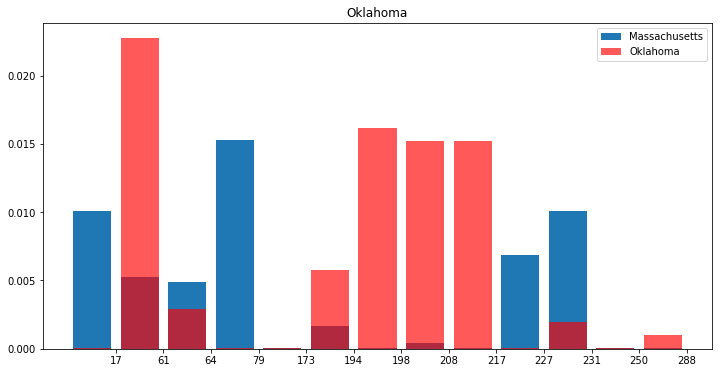

In [92]:
author_id = 13
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(good_topics)), normalized_AT[author_id,good_topics],label=author_name[author_id])
author_id = 20
plt.bar(range(len(good_topics)), normalized_AT[author_id,good_topics],color='r',alpha=0.65,label=author_name[author_id])
# author_id = 10
# plt.bar(range(len(good_topics)), normalized_AT[author_id,good_topics],color='g',alpha=0.65,label=author_name[author_id])

plt.legend()
plt.title(author_name[author_id])
# plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(model.TW, voca, k, 10)) for k in range(n_topic)])
plt.xticks(np.arange(len(good_topics))+0.5, good_topics)
plt.show()

In [243]:
target=np.array(red_means)[good_topics]

In [249]:
# target

In [108]:
def NN(good_topics,target):
    scores = normalized_AT[:,good_topics] @ target

    lda_pred=[]
    ranked_pairs = sorted([(i,scores[i]) for i in range(len(scores))],key=lambda pair:pair[1],reverse=True)
    for pair in ranked_pairs:
#         print(author_name[pair[0]])
        lda_pred.append(author_name[pair[0]].lower())
    return lda_pred

In [166]:
from sklearn.ensemble import RandomForestClassifier

/home/yicheng/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [244]:
def log_reg(good_topics):
    X_red=normalized_AT[red_states_ids,:][:,good_topics]
    Y_red=np.zeros((X_red.shape[0]))+1

    X_blue=normalized_AT[blue_states_ids,:][:,good_topics]
    Y_blue=np.zeros((X_blue.shape[0]))

    Y=np.concatenate((Y_red,Y_blue),axis=0)

    X=np.concatenate((X_red,X_blue),axis=0)

    cl = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=0)
#     cl = LogisticRegression(C=1e5, solver='lbfgs')

    cl.fit(X, Y)

    score_rank=sorted(list(zip(author_name,cl.predict_proba(normalized_AT[:,good_topics])[:,1])),key=lambda x: x[1],reverse=True)
    lda_pred=[]
    for pair in score_rank:
        lda_pred.append(author_name[pair[0]].lower())
    return lda_pred

In [245]:
lda_pred=log_reg(good_topics)
print(lda_pred)

['alabama', 'kansas', 'kentucky', 'south carolina', 'louisiana', 'texas', 'tennessee', 'oklahoma', 'georgia', 'indiana', 'arizona', 'north carolina', 'wisconsin', 'ohio', 'virginia', 'michigan', 'florida', 'colorado', 'pennsylvania', 'minnesota', 'california', 'new jersey', 'maryland', 'illinois', 'massachusetts', 'washington', 'new york', 'oregon', 'district of columbia']


In [247]:
lda_pred=NN(good_topics,target)
print(lda_pred)

['south carolina', 'alabama', 'kentucky', 'arizona', 'texas', 'tennessee', 'california', 'georgia', 'oklahoma', 'kansas', 'indiana', 'florida', 'louisiana', 'ohio', 'colorado', 'washington', 'north carolina', 'new york', 'michigan', 'pennsylvania', 'new jersey', 'illinois', 'oregon', 'virginia', 'maryland', 'massachusetts', 'wisconsin', 'minnesota', 'district of columbia']


In [250]:
simple_rank_loss(new_truth,lda_pred)

0.7740784780023782

In [56]:
import pickle as pkl
with open('truth.pkl','rb') as file:
    truth=pkl.load(file)
with open('web_pred.pkl','rb') as file:
    web_pred=pkl.load(file)

In [57]:
new_truth=[]

states_lower=list(map(lambda x:x.lower(),author_name.values()))
for state in truth:
    if state in set(states_lower):
        new_truth.append(state)

In [58]:
new_wpred=[]

states_lower=list(map(lambda x:x.lower(),author_name.values()))
for state in web_pred:
    if state in set(states_lower):
        new_wpred.append(state)

In [59]:

def simple_rank_loss(new_truth,lda_pred):
    truth_rank={}
    n=0
    for state in new_truth:
        truth_rank[state]=n
        n+=1


    truth_binary_rank={}
    for k in range(len(new_truth)):
        for j in range(len(new_truth)):
            if truth_rank[new_truth[k]]<truth_rank[new_truth[j]]:
                truth_binary_rank[(new_truth[k],new_truth[j])]=1
            else:
                truth_binary_rank[(new_truth[k],new_truth[j])]=0


    pred_rank={}
    n=0
    for state in lda_pred:
        pred_rank[state]=n
        n+=1


    pred_binary_rank={}
    for k in range(len(lda_pred)):
        for j in range(len(lda_pred)):
            if pred_rank[lda_pred[k]]<pred_rank[lda_pred[j]]:
                pred_binary_rank[(lda_pred[k],lda_pred[j])]=1
            else:
                pred_binary_rank[(lda_pred[k],lda_pred[j])]=0

    assert len(truth_binary_rank.values()) == len(pred_binary_rank.values())

    correct=0
    for key in pred_binary_rank.keys():
        if pred_binary_rank[key] == truth_binary_rank[key]:
            correct+=1

    return correct/len(pred_binary_rank.keys())

In [349]:
simple_rank_loss(new_truth,new_wpred)

0.9595719381688466

Bootstrap ends

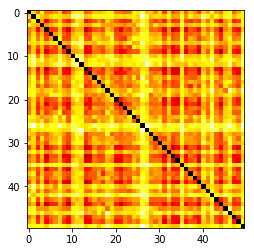

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(comp, cmap='hot', interpolation='nearest')
plt.show()

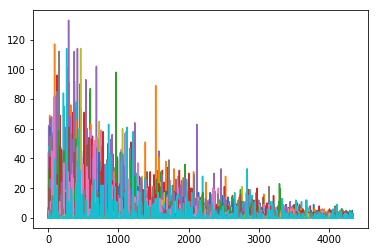

In [46]:
for i in range(50):
    plt.plot(model.TW[i,:])

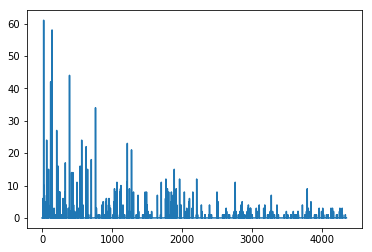

In [44]:
plt.plot(model.TW[30,:])

In [49]:
model.AT.shape

(52, 50)

In [113]:
author_name

{0: 'Alabama',
 1: 'Arizona',
 2: 'California',
 3: 'Colorado',
 4: 'District of Columbia',
 5: 'Florida',
 6: 'Georgia',
 7: 'Illinois',
 8: 'Indiana',
 9: 'Kansas',
 10: 'Kentucky',
 11: 'Louisiana',
 12: 'Maryland',
 13: 'Massachusetts',
 14: 'Michigan',
 15: 'Minnesota',
 16: 'New Jersey',
 17: 'New York',
 18: 'North Carolina',
 19: 'Ohio',
 20: 'Oklahoma',
 21: 'Oregon',
 22: 'Pennsylvania',
 23: 'South Carolina',
 24: 'Tennessee',
 25: 'Texas',
 26: 'Virginia',
 27: 'Washington',
 28: 'Wisconsin'}

In [56]:
dists=model.AT


topic_dist=pd.DataFrame(dists)

topic_dist['state']=list(author_name.values())

# topic_dist.sort_values(by=[1],ascending=False)

In [57]:
topic_dist

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,state
0,28.1,6.1,2.1,30.1,48.1,60.1,22.1,13.1,18.1,2.1,...,36.1,0.1,0.1,9.1,11.1,8.1,12.1,0.1,40.1,Alabama
1,12.1,4.1,0.1,0.1,0.1,0.1,7.1,2.1,0.1,0.1,...,0.1,6.1,0.1,0.1,0.1,8.1,0.1,0.1,8.1,Alaska
2,18.1,125.1,2.1,107.1,88.1,10.1,131.1,19.1,104.1,35.1,...,4.1,0.1,37.1,60.1,43.1,5.1,14.1,1.1,76.1,Arizona
3,18.1,19.1,0.1,0.1,4.1,0.1,3.1,21.1,0.1,1.1,...,0.1,2.1,0.1,5.1,18.1,0.1,0.1,0.1,20.1,Arkansas
4,80.1,142.1,55.1,122.1,115.1,0.1,110.1,67.1,147.1,24.1,...,54.1,139.1,88.1,32.1,99.1,201.1,38.1,0.1,135.1,California
5,35.1,41.1,0.1,28.1,56.1,0.1,29.1,0.1,19.1,183.1,...,102.1,16.1,6.1,21.1,18.1,47.1,8.1,0.1,43.1,Colorado
6,0.1,11.1,0.1,19.1,6.1,0.1,4.1,0.1,40.1,0.1,...,0.1,10.1,28.1,7.1,0.1,23.1,1.1,0.1,26.1,Connecticut
7,1.1,0.1,0.1,1.1,4.1,3.1,10.1,10.1,5.1,3.1,...,0.1,3.1,3.1,0.1,0.1,8.1,2.1,0.1,0.1,Delaware
8,10.1,74.1,51.1,44.1,134.1,1.1,44.1,43.1,49.1,3.1,...,0.1,35.1,34.1,48.1,53.1,70.1,20.1,0.1,131.1,District of Columbia
9,115.1,124.1,60.1,126.1,103.1,57.1,117.1,93.1,119.1,21.1,...,2.1,76.1,69.1,51.1,0.1,86.1,38.1,5.1,89.1,Florida
